Importing necessary libraries

In [1]:
import sys
sys.path.append('../')
import stan_utility
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd

import scipy.stats as stats
import matplotlib as mpl

C:\Users\kubag\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

Exercise 1. We assume that the death rate is constant and doesn't depend on anything

Presenting CSV flight accidents data

In [3]:
data = pd.read_csv('airlines.csv')
data.head(10)

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0
5,1981,21,362,0.06,6033.0
6,1982,26,764,0.13,5877.0
7,1983,20,809,0.13,6223.0
8,1984,16,223,0.03,7433.0
9,1985,22,1066,0.15,7107.0


We can assume that the number of passenger deaths over 6 per day is very improbable. Approximately to have no more than 1% probability we can assume (from three sigma rule):
$$\lambda + 3 \sqrt{\lambda} \approx 2190$$

In [4]:
root_of_lambda = np.polynomial.polynomial.polyroots([-2190, 3., 1.])
lambda_ub = np.round(root_of_lambda[root_of_lambda>0]**2)
print("Lambda root= ", lambda_ub)

Lambda root=  [2054.]


We need to find $\sigma$ value that would guarantee the probability lying below 99%. We can extract it using stan algebra solver

In [5]:
with open('prior_tuning.stan') as f:
    print(f.read())

functions {
	vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i){
		vector[1] deltas;
		deltas[1] = 2* (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) -0.99;
		return deltas;
	}
}

data {
	vector[1] y_guess;
	vector[1] theta;	
}

transformed data{
	vector[1] y;
	real x_r[0];
	int x_i[0];
	
	y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
}

generated quantities {
  real sigma = exp(y[1]);
}


In [6]:
tuning = stan_utility.compile_model('prior_tuning.stan')

Using cached StanModel


In [7]:
_data=dict(y_guess=np.array([np.log(500)]),theta=np.array(lambda_ub))
tuned = tuning.sampling(data=_data,
                          seed=20202020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned.extract()['sigma'][0])
print("sigma= ", sigma)

sigma=  797.0


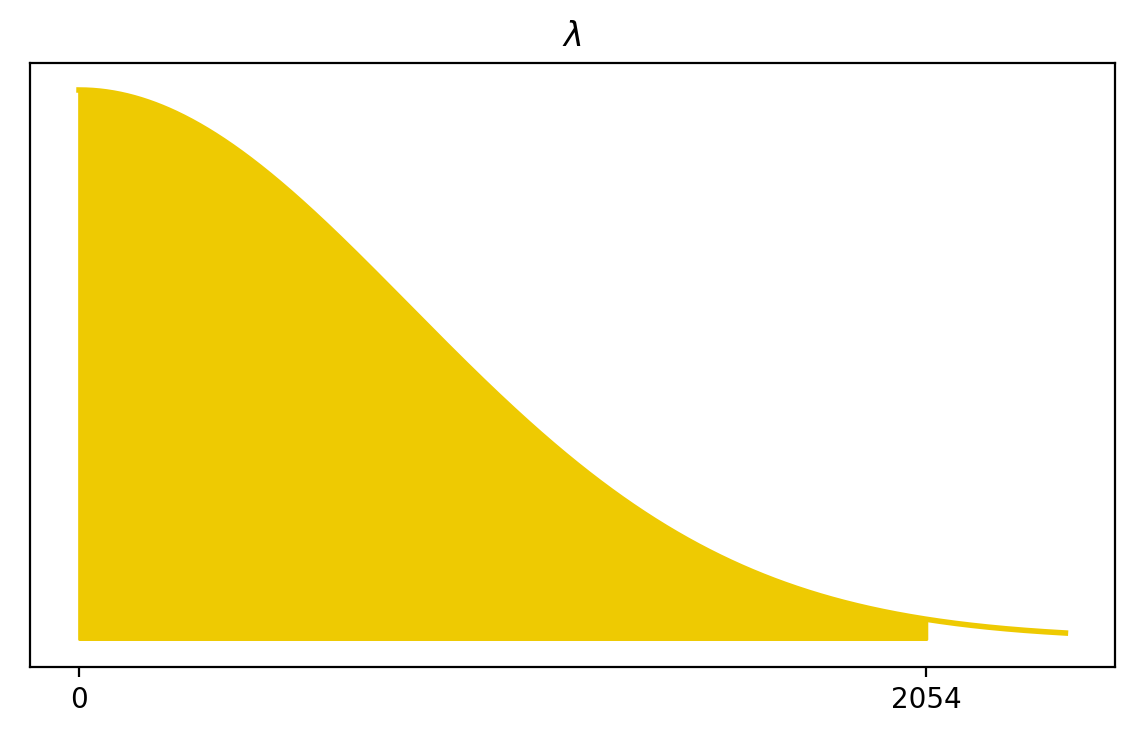

In [8]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lambda_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lambda_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

Now let's use stan to predict deat rate based only on prior information

In [9]:
with open('deathrate_only_prior.stan') as f:
    print(f.read())

data{
	int sigma;	//poisson lambda argument
}

generated quantities{
	real lambda = fabs(normal_rng(0, sigma));
	int y_sim = poisson_rng(lambda);
}


In [10]:
model_prior = stan_utility.compile_model('deathrate_only_prior.stan')

Using cached StanModel


In [11]:
R=1000
fit_prior = model_prior.sampling(data={'sigma': int(sigma)},
                          algorithm="Fixed_param",
                          iter=R,
                          warmup=0,
                          chains=1,
                          seed = 20202020)

In [12]:
paramsLambda = pd.DataFrame(fit_prior.extract()['lambda'])
paramsDeaths = pd.DataFrame(fit_prior.extract()['y_sim'])
params = paramsLambda.merge(paramsDeaths, left_index = True, right_index = True)
params.columns = ['lambda', 'deaths']

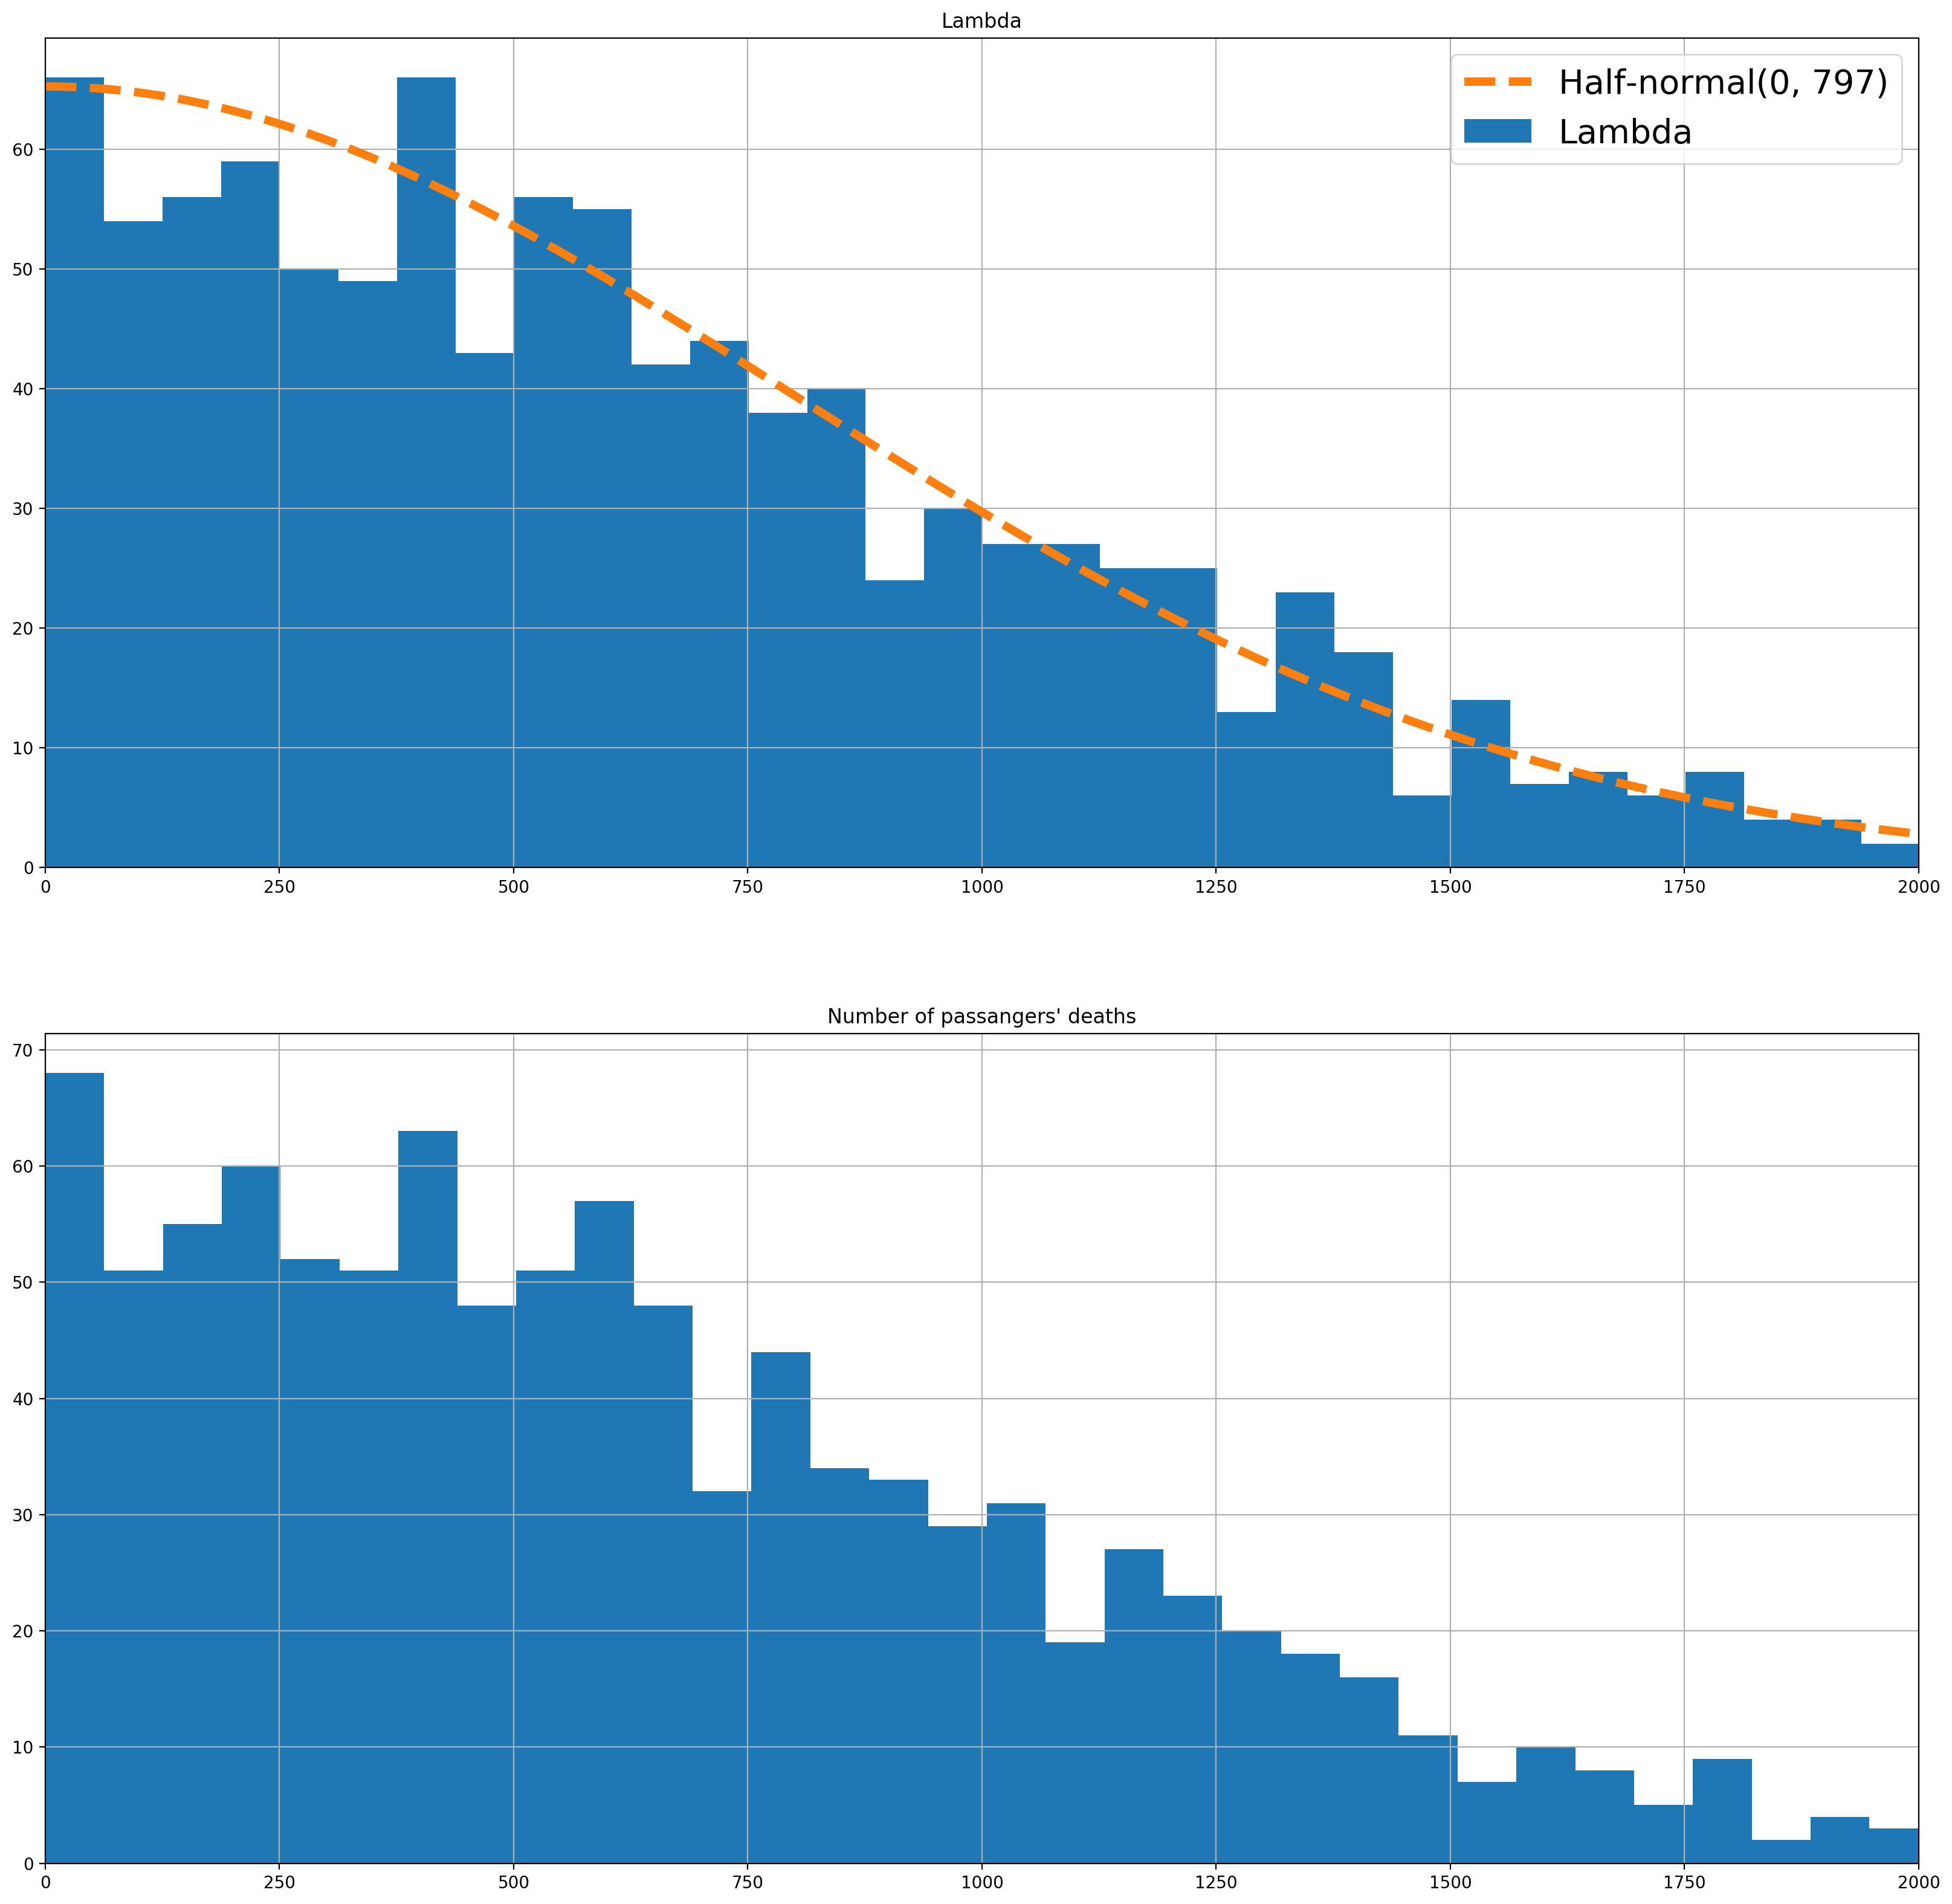

In [13]:
#We plot the histograms of lambda and number of deaths.
fig, axes = plt.subplots(2, 1, figsize = [20, 20])
ax1 = axes[0]
x = np.linspace(0, 2000, 20000)
ax1.set_title('Lambda')
ax1.set_xlim([0, 2000])
ax1.hist(params['lambda'], bins = 50, label = 'Lambda')
ax1.plot(x, 130333*stats.norm.pdf(x, 0, 797), '--', linewidth = 5, label = 'Half-normal(0, 797)')
ax1.grid()
ax1.legend(prop = {'size': 20})
ax2 = axes[1]
ax2.set_title('Number of passangers\' deaths')
ax2.set_xlim([0, 2000])
ax2.hist(params['deaths'], bins = 50)
ax2.grid()
plt.show()

## Posterior inference and posterior predictive checks

In [14]:
with open('deathrate_posterior_checks.stan') as f:
    print(f.read())

data{
	int M;	//years to be analyzed
	int y[M]; //death rate in percents
	int sigma;
}

parameters{
	real<lower=0> lambda;
}

model{
	lambda ~ normal(0,sigma);
	for(k in 1:M){
		y[k]~poisson(lambda);
	}
}

generated quantities{
	int y_sim[M];
	for(k in 1:M){
		y_sim[k] = poisson_rng(lambda);
	}
}


In [15]:
posterior_model = stan_utility.compile_model('deathrate_posterior_checks.stan')

Using cached StanModel


In [16]:
_data = dict(M = data.shape[0],
            y = data['Passenger deaths'],
            sigma = int(sigma))
posterior_fit = posterior_model.sampling(data=_data, seed=20202020)

lambdaParams = posterior_fit.extract()['lambda']
deathsParams = posterior_fit.extract()['y_sim'].flatten()

In [17]:
meanLambda = np.mean(lambdaParams)
confInterval = az.hpd(lambdaParams, 0.95)
print('Mean lambda: {}, 95% confidence interval: ({}, {})'.format(meanLambda, confInterval[0], confInterval[1]))

Mean lambda: 691.7839038446718, 95% confidence interval: (675.6618192207834, 707.8818166563204)


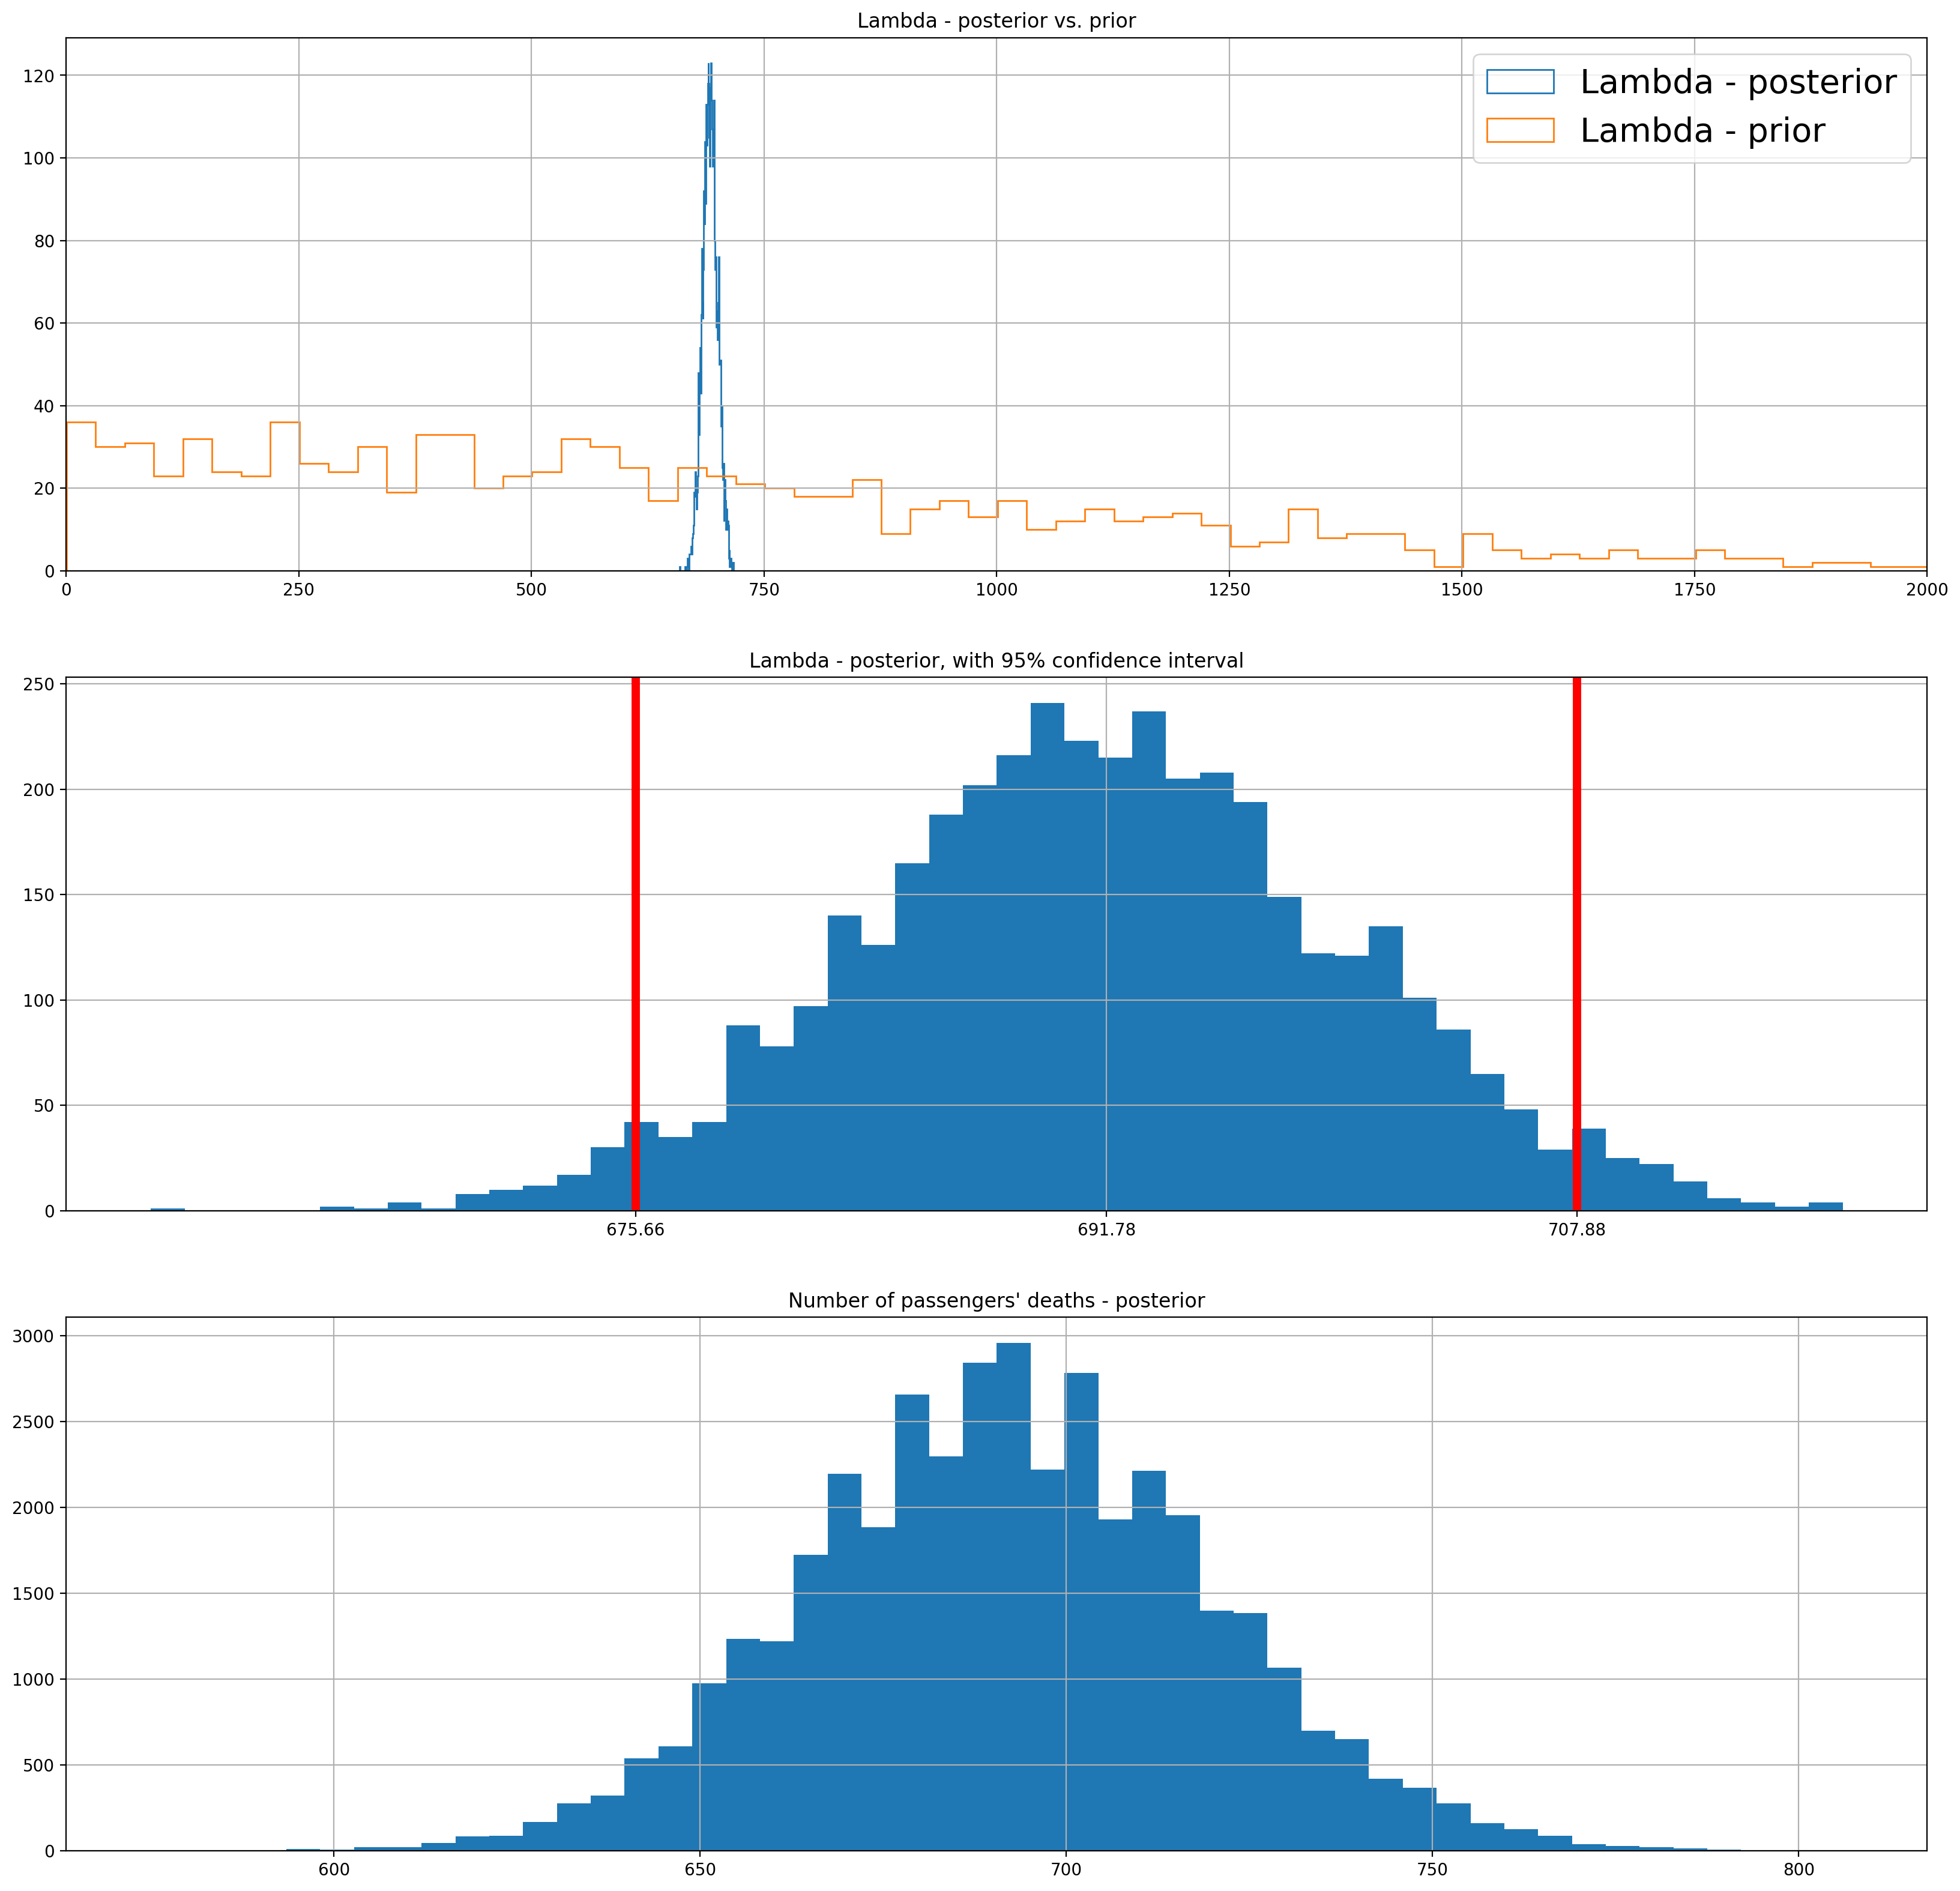

In [20]:
fig, axes = plt.subplots(3, 1, figsize = [20, 20])
ax1 = axes[0]
ax1.set_title('Lambda - posterior vs. prior')
ax1.set_xlim([0, 2000])
ax1.hist(lambdaParams, bins = 100, histtype = 'step', label = 'Lambda - posterior')
ax1.hist(params['lambda'], bins = 100, histtype = 'step', label = 'Lambda - prior')
ax1.grid()
ax1.legend(prop = {'size': 20})
ax2 = axes[1]
ax2.set_title('Lambda - posterior, with 95% confidence interval')
ax2.hist(lambdaParams, bins = 50)
ax2.set_xticks([confInterval[0], meanLambda, confInterval[1]])
ax2.axvline(confInterval[0], linewidth = 5, color = 'red')
ax2.axvline(confInterval[1], linewidth = 5, color = 'red')
ax2.grid()
ax3 = axes[2]
ax3.set_title('Number of passengers\' deaths - posterior')
ax3.hist(deathsParams, bins = 50)
ax3.grid()
plt.show()

## Using model for prediction
Let's test the model prediction i.e. for year 1980. In that year, there had been 22 fatal accidents with 814 passenger deaths, death rate 0.14 and 5814 mln miles flown

In [21]:
meanDeaths = np.mean(deathsParams)
confIntervalDeaths = az.hpd(deathsParams, 0.95)
print('Mean of predicted passengers\'s deaths: {}, 95% confidence interval: ({}, {})'.
      format(meanDeaths, confIntervalDeaths[0], confIntervalDeaths[1]))

Mean of predicted passengers's deaths: 692.11705, 95% confidence interval: (638.0, 745.0)


## Considering miles flown
It can be stated that number of passenger deaths is related to number of miles flown. However, we can still use Poisson distribution, but with $\lambda$ decomposed into intensity $\theta$ and exposure $n$. Once again from three sigma rules we can assume that having death rate near 100% is very improbable. To compute the bounds we can use the formula:
$$\theta \overline{n} + 3\sqrt{\theta \overline{n}} \approx 2190$$, where $\overline{n}$ is the mean number of miles flown.

With the use of stan algebra solver we want to assign prior for $\theta$ that would have the probability samller than 99%

In [124]:
#calculating mean miles flown
mean_miles = np.mean(data['Miles flown [100 mln miles]'])
root_of_theta = np.roots([1, 3., -2190])
theta_ub = root_of_theta[root_of_lambda>0]**2/mean_miles
print('{}'.format(theta_ub[0]))

0.35936099788248127


Presenting model for algebra solver

In [125]:
with open('intensity_prior.stan') as f:
    print(f.read())

functions {
    vector tail_halfNormal (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[1] deltas;
        deltas[1] = 2*(normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
        return deltas;
    }
}
data {
    vector[1] y_guess;
    vector[1] theta;
}
transformed data {
    vector[1] y;
    real x_r[0];
    int x_i[0];
    y = algebra_solver(tail_halfNormal, y_guess, theta, x_r, x_i);
}
generated quantities {
    real sigma = exp(y[1]);
}


In [126]:
intensity_prior = stan_utility.compile_model('intensity_prior.stan')

Using cached StanModel


In [127]:
_data = {'y_guess': np.array([np.log(0.1)]), 'theta': np.array([theta_ub[0]])}
intensity_prior_fit = intensity_prior.sampling(data = _data, algorithm = 'Fixed_param', iter = 1)
print('Sigma: {}'.format(intensity_prior_fit.extract()['sigma'][0]))

Sigma: 0.13951273765981476


The $\sigma$ parameter above guarantees that having half-normal distribution (0, 0.13) will give us the 99% probability below 0.35. We can define model to create prior distribution.

In [128]:
with open('miles_prior.stan') as f:
    print(f.read())

data {
	real sigma;
    int M;
    vector[M] miles;
}
generated quantities {
    real theta = fabs(normal_rng(0, sigma));
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(theta*miles[k]);
    }
}


In [129]:
miles_model_prior = stan_utility.compile_model('miles_prior.stan')

Using cached StanModel


In [130]:
_data = dict(sigma = intensity_prior_fit.extract()['sigma'][0], M = data.shape[0], miles = data['Miles flown [100 mln miles]'])
miles_prior_fit = miles_model_prior.sampling(data=_data, seed=2020202, algorithm="Fixed_param", iter=1000)
paramsTheta = pd.DataFrame(miles_prior_fit.extract()['theta'])
paramsDeaths = pd.DataFrame(miles_prior_fit.extract()['y_sim'])
params = paramsTheta.merge(paramsDeaths, left_index = True, right_index = True)

Now we can plot the histograms with generated values

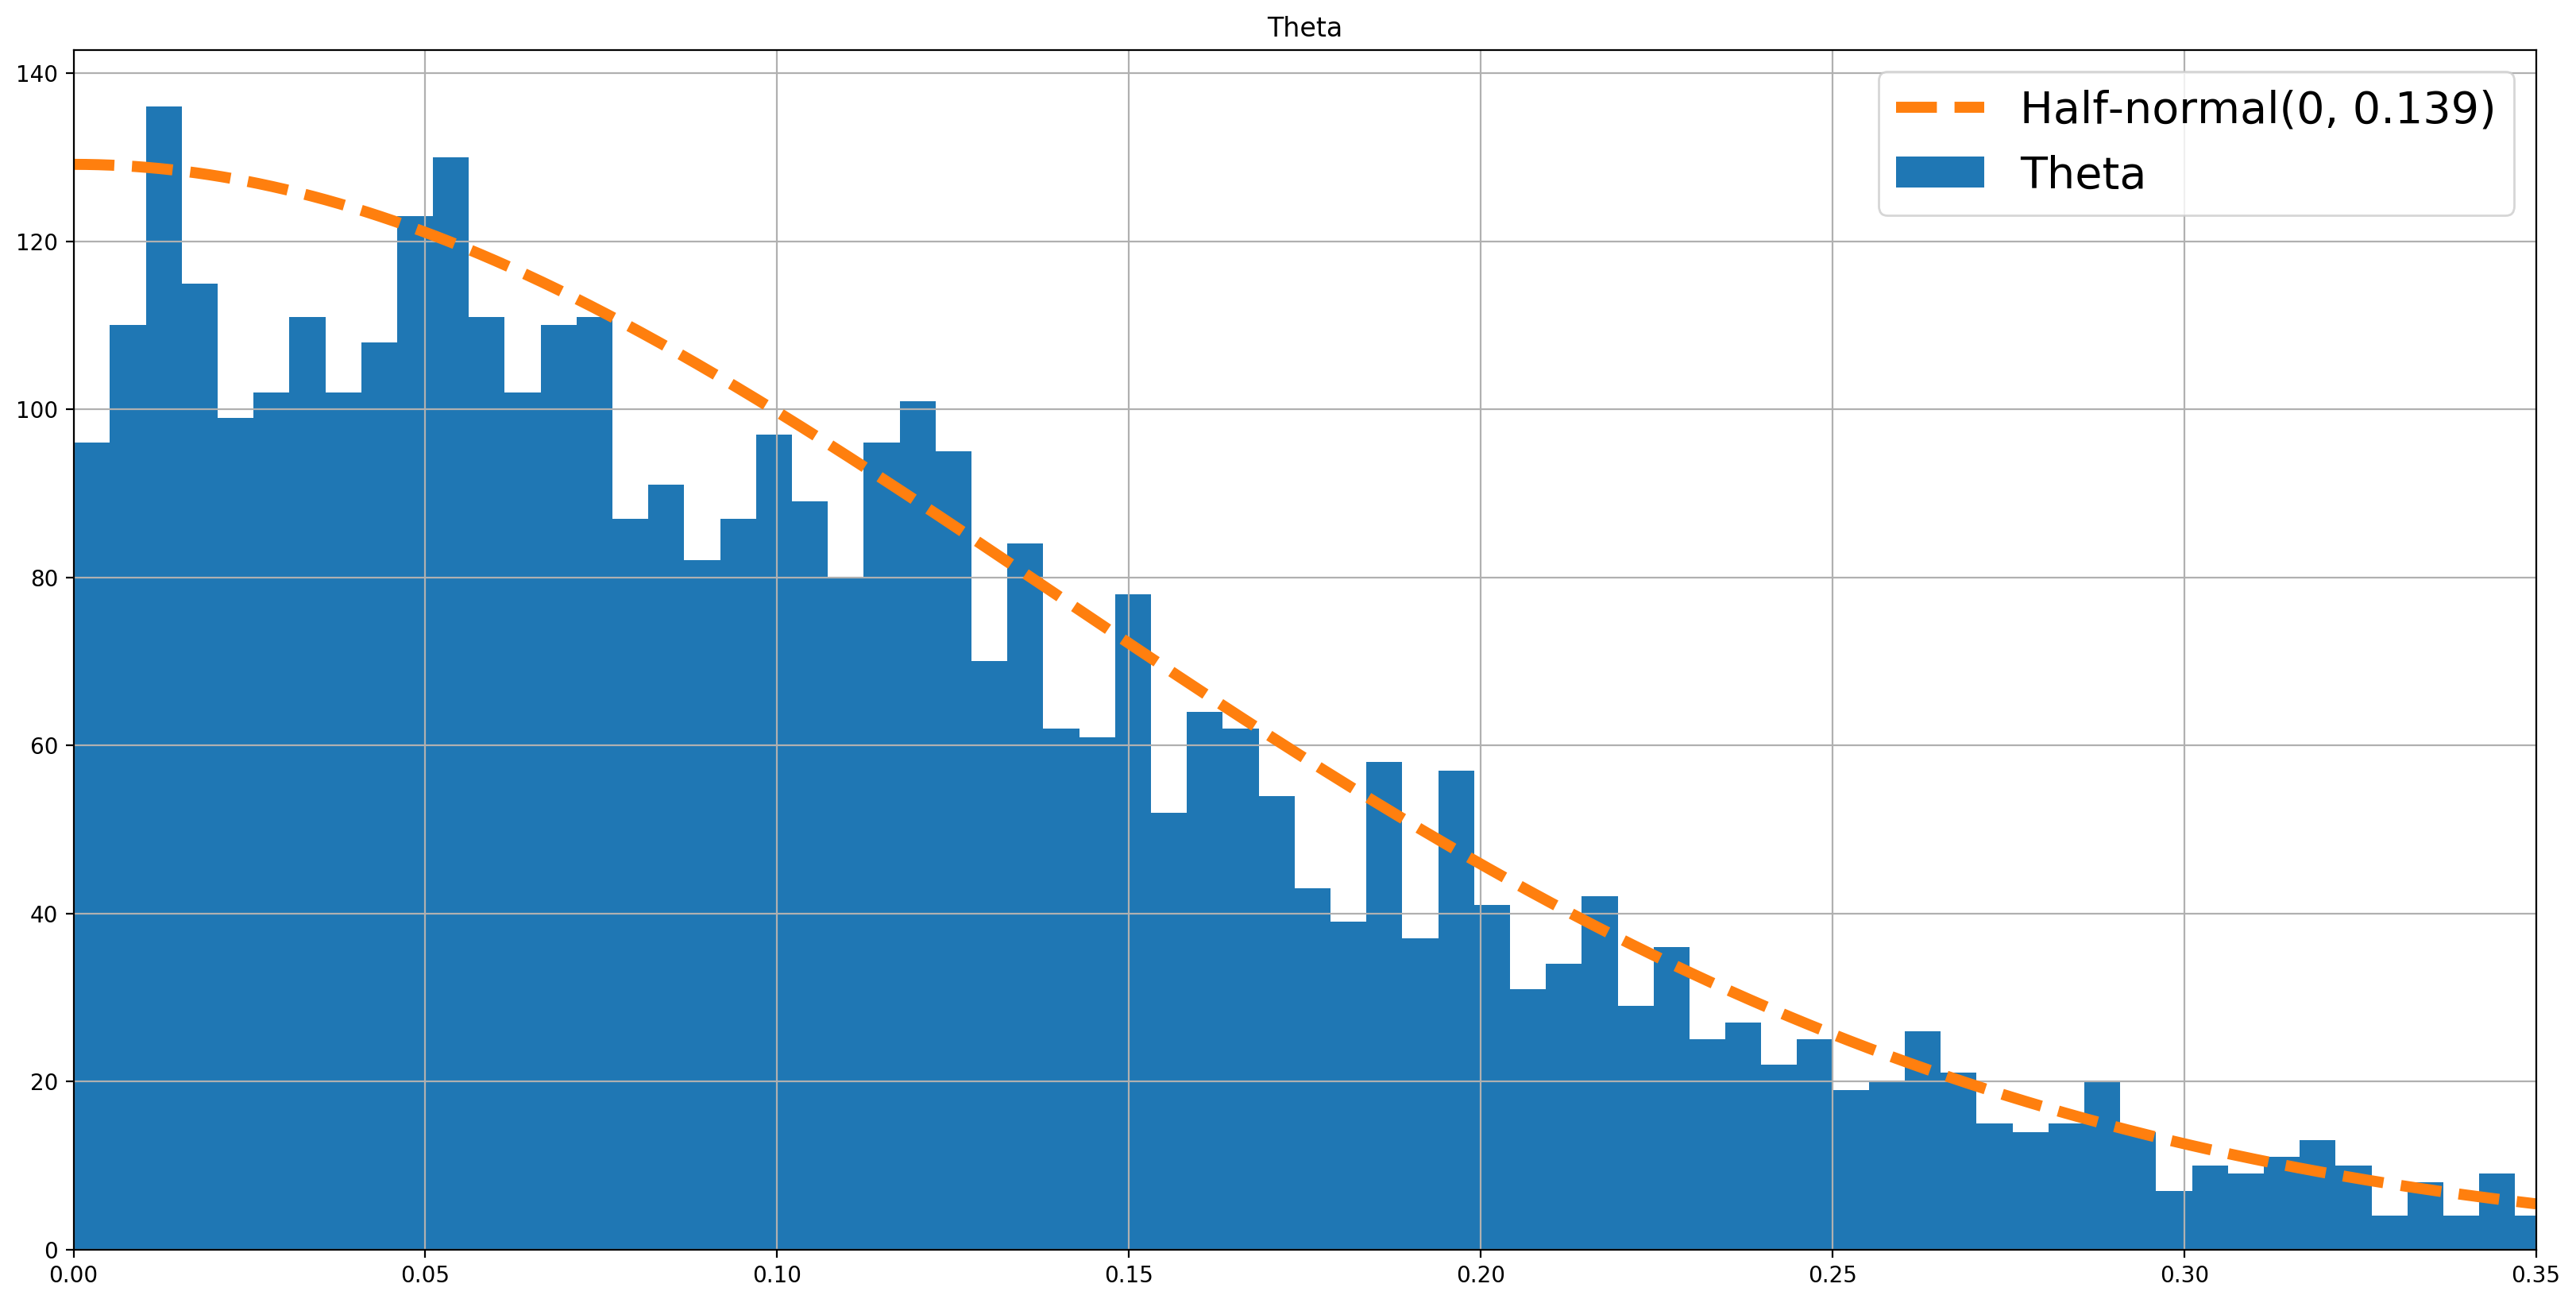

In [131]:
plt.figure(figsize = [20, 10])
plt.title('Theta')
plt.xlim([0, 0.35])
plt.hist(params.iloc[:, 0], bins = 100, label = 'Theta')
x = np.linspace(0, 0.35, 2000)
plt.plot(x, 45*stats.norm.pdf(x, 0, 0.139), '--', linewidth = 5, label = 'Half-normal(0, 0.139)')
plt.grid()
plt.legend(prop = {'size': 20})
plt.show()

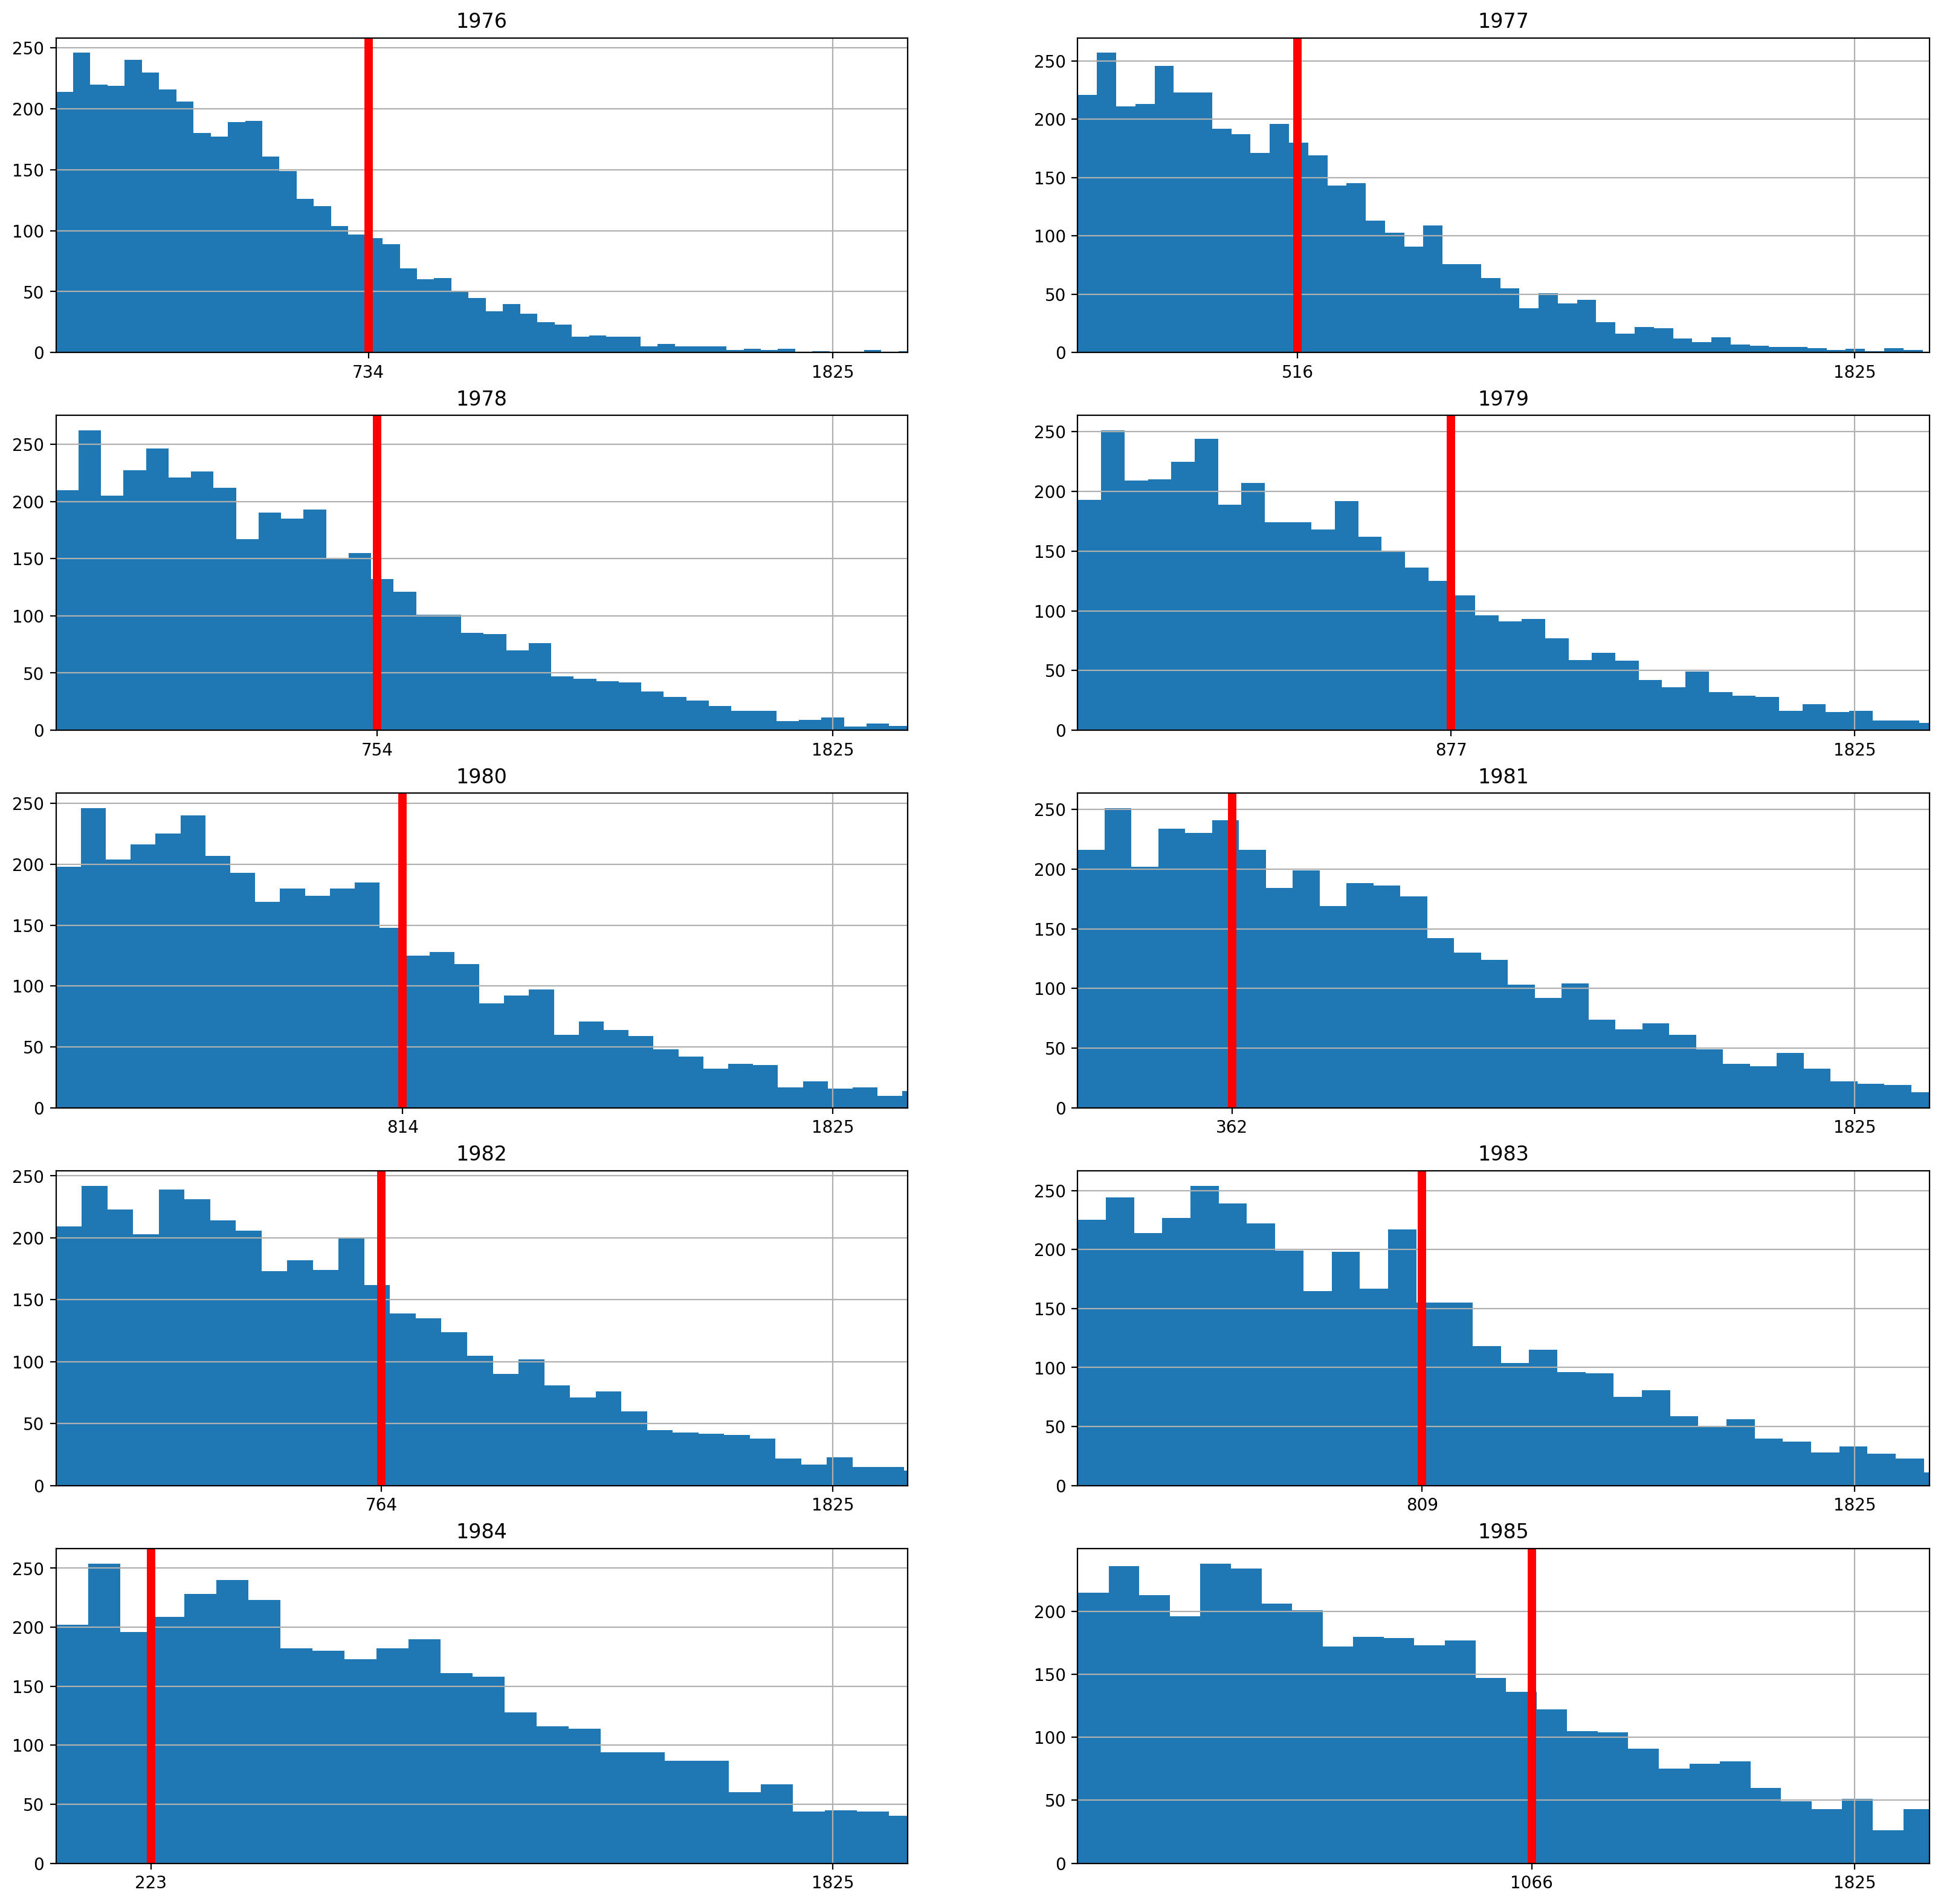

In [132]:
fig, axes = plt.subplots(5, 2, figsize = [20, 20])
for k in range(len(axes.flatten())):
    ax = axes.flatten()[k]
    ax.set_title('{}'.format(data.iloc[k, 0]))
    ax.axvline(data.iloc[k, 2], linewidth = 5, color = 'red')
    ax.set_xlim([0, 2000])
    ax.set_xticks([data.iloc[k, 2], 1825])
    ax.hist(params.iloc[:, k + 1], bins = 50)
    ax.grid()
plt.show()

## Model with posterior inference

In [133]:
with open('miles_posterior.stan') as f:
    print(f.read())

data {
	real sigma;
    int M;
    vector[M] miles;
    int y[M];
}
parameters {
    real<lower=0>theta;
}
model {
    theta ~ normal(0, sigma);
    for (k in 1:M) {
        y[k] ~ poisson(miles[k]*theta);
    }
}
generated quantities {
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(miles[k]*theta);
    }
}


In [134]:
miles_model_posterior = stan_utility.compile_model('miles_posterior.stan')

Using cached StanModel


In [139]:
_data = {'M': data.shape[0], 'miles': data['Miles flown [100 mln miles]'], 'y': data['Passenger deaths'], 'sigma':0.139}
miles_posterior_fit = miles_model_posterior.sampling(data=_data, seed=2020202)
paramsTheta = pd.DataFrame(miles_posterior_fit.extract()['theta'])
paramsDeaths = pd.DataFrame(miles_posterior_fit.extract()['y_sim'])
paramsPost = paramsTheta.merge(paramsDeaths, left_index = True, right_index = True)

In [140]:
meanTheta = np.mean(paramsPost.iloc[:,0])
confInterval = az.hpd(paramsPost.iloc[:,0], 0.9)
print('Mean theta: {}, 95% confidence interval: ({}, {})'.format(meanTheta, confInterval[0], confInterval[1]))

Mean theta: 0.1210622362657445, 95% confidence interval: (0.1185784273791337, 0.1232391114663251)


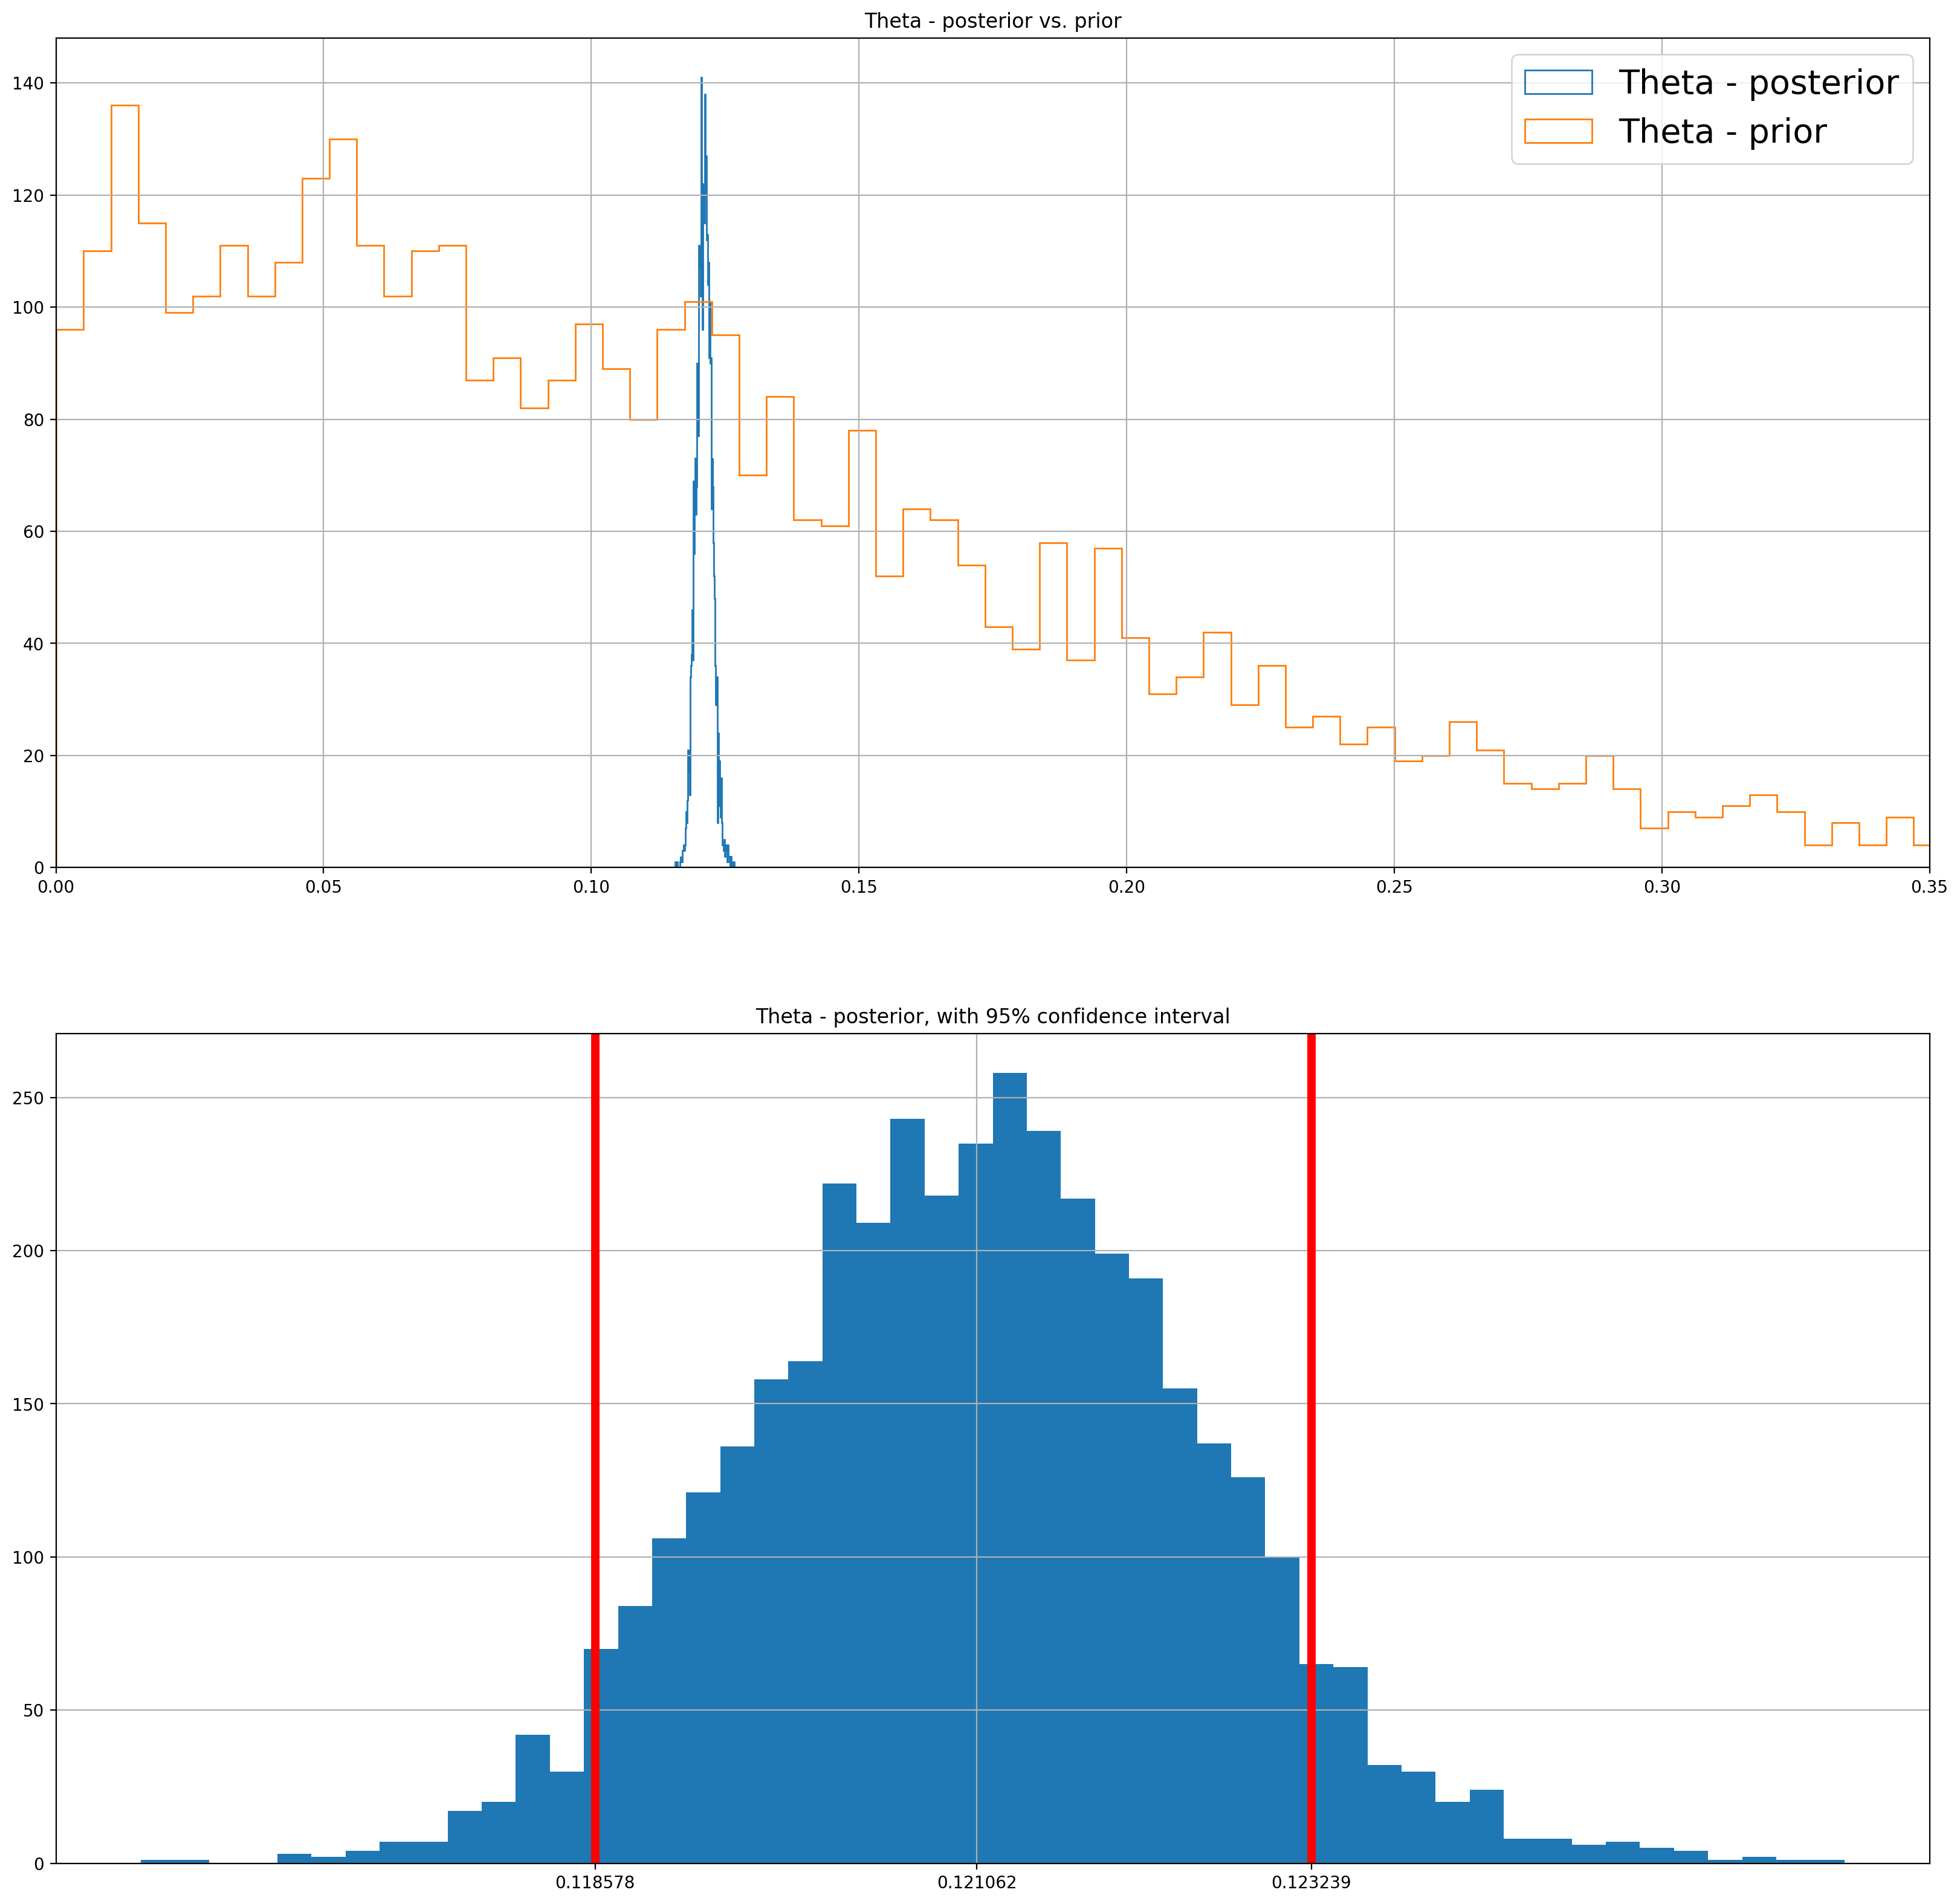

In [141]:
fig, ax = plt.subplots(2, 1, figsize = [20, 20])
ax1 = ax[0]
ax1.set_title('Theta - posterior vs. prior')
ax1.set_xlim([0, 0.35])
ax1.hist(paramsPost.iloc[:, 0], bins = 100, histtype = 'step', label = 'Theta - posterior')
ax1.hist(params.iloc[:, 0], bins = 100, histtype = 'step', label = 'Theta - prior')
ax1.grid()
ax1.legend(prop = {'size': 20})
ax2 = ax[1]
ax2.set_title('Theta - posterior, with 95% confidence interval')
ax2.hist(paramsPost.iloc[:, 0], bins = 50)
ax2.set_xticks([confInterval[0], meanTheta, confInterval[1]])
ax2.axvline(confInterval[0], linewidth = 5, color = 'red')
ax2.axvline(confInterval[1], linewidth = 5, color = 'red')
ax2.grid()
plt.show()

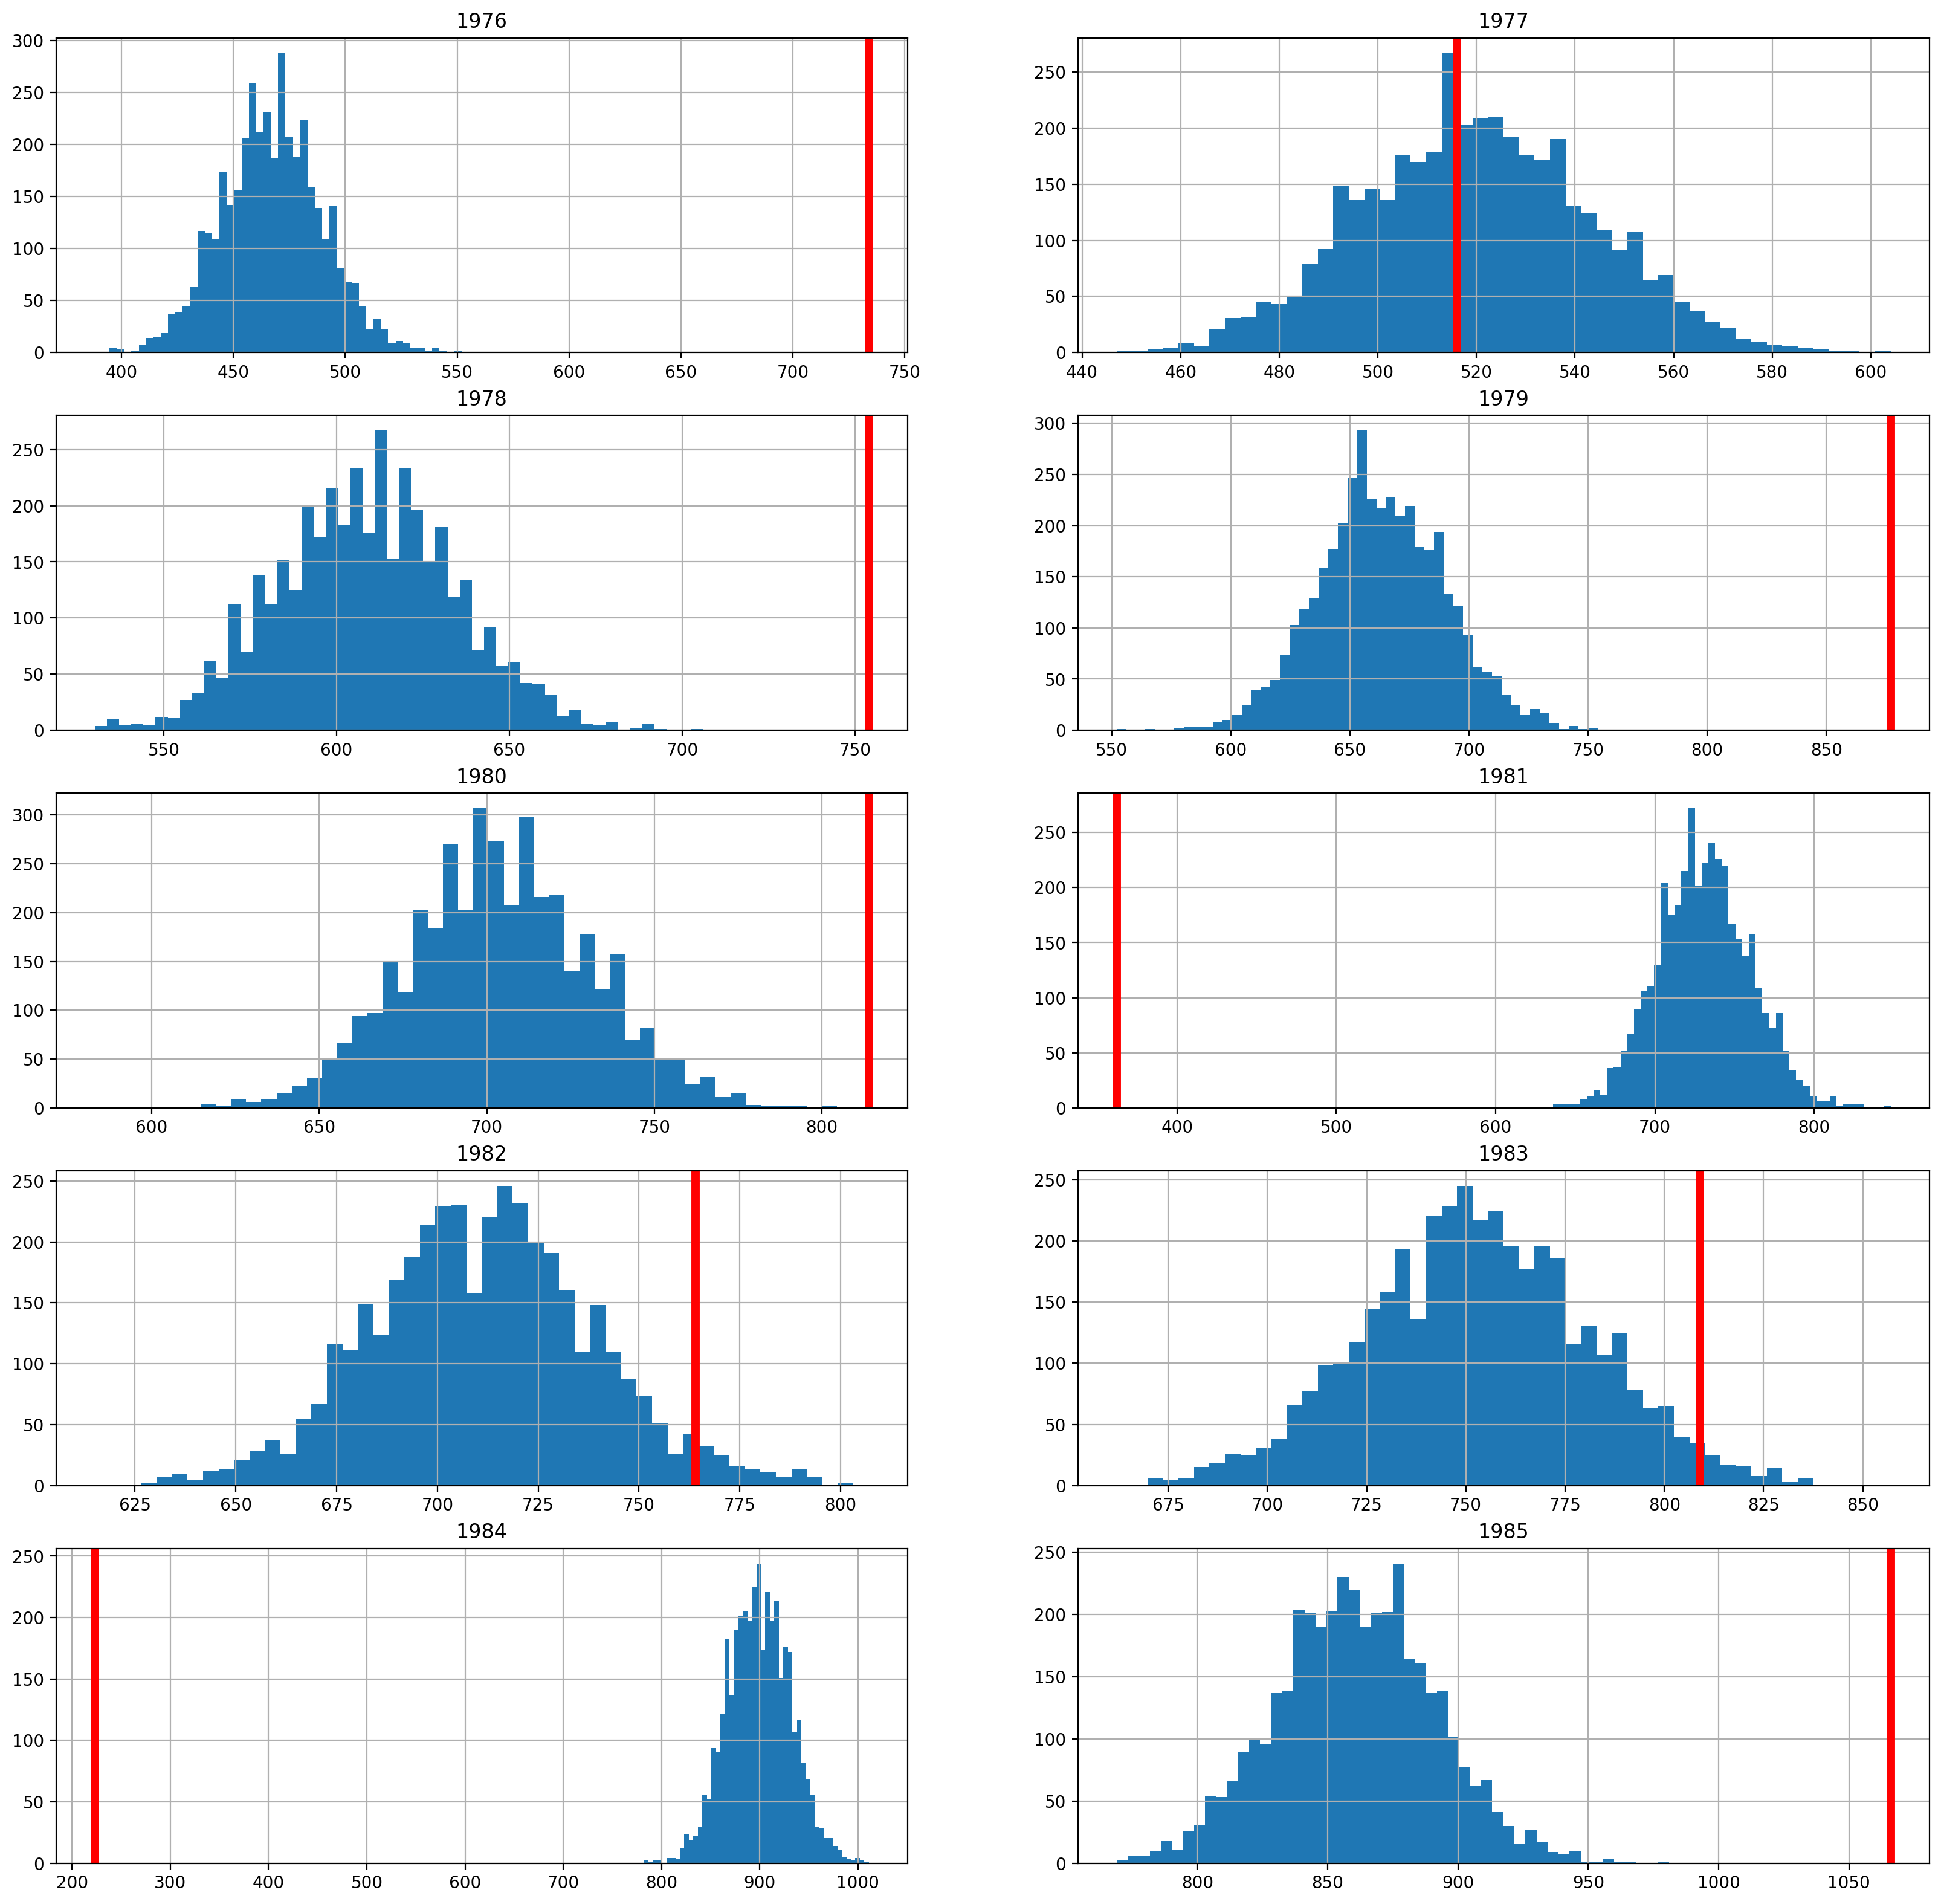

In [142]:
fig, axes = plt.subplots(5, 2, figsize = [20, 20])
for k in range(len(axes.flatten())):
    ax = axes.flatten()[k]
    ax.set_title('{}'.format(data.iloc[k, 0]))
    ax.axvline(data.iloc[k, 2], linewidth = 5, color = 'red')
    ax.hist(paramsPost.iloc[:, k + 1], bins = 50)
    ax.grid()
plt.show()

## Prediction for year 1986
Now we will predict the number of passengers' deaths in 1986. Knowing that there were 9100*100 mln miles flown that year,
we make the next model.

In [143]:
model_1986 = stan_utility.compile_model('predict_1986.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_986807a14451ef4a6cfa2d598d69469f NOW.


In [145]:
_data = {'M': data.shape[0], 'miles': data['Miles flown [100 mln miles]'], 'y': data['Passenger deaths'], 'sigma': 0.139}
fit_predict1986 = model_1986.sampling(data = _data)
params1986 = fit_predict1986.extract()['y1986']
meanDeaths = np.mean(params1986)
confIntervalPredict = az.hpd(params1986, 0.95)
print('Mean of predicted passengers\' deaths: {}, 95% confidence interval: ({}, {})'.
     format(meanDeaths, confIntervalPredict[0], confIntervalPredict[1]))

Mean of predicted passengers' deaths: 1100.7495, 95% confidence interval: (1031.0, 1169.0)


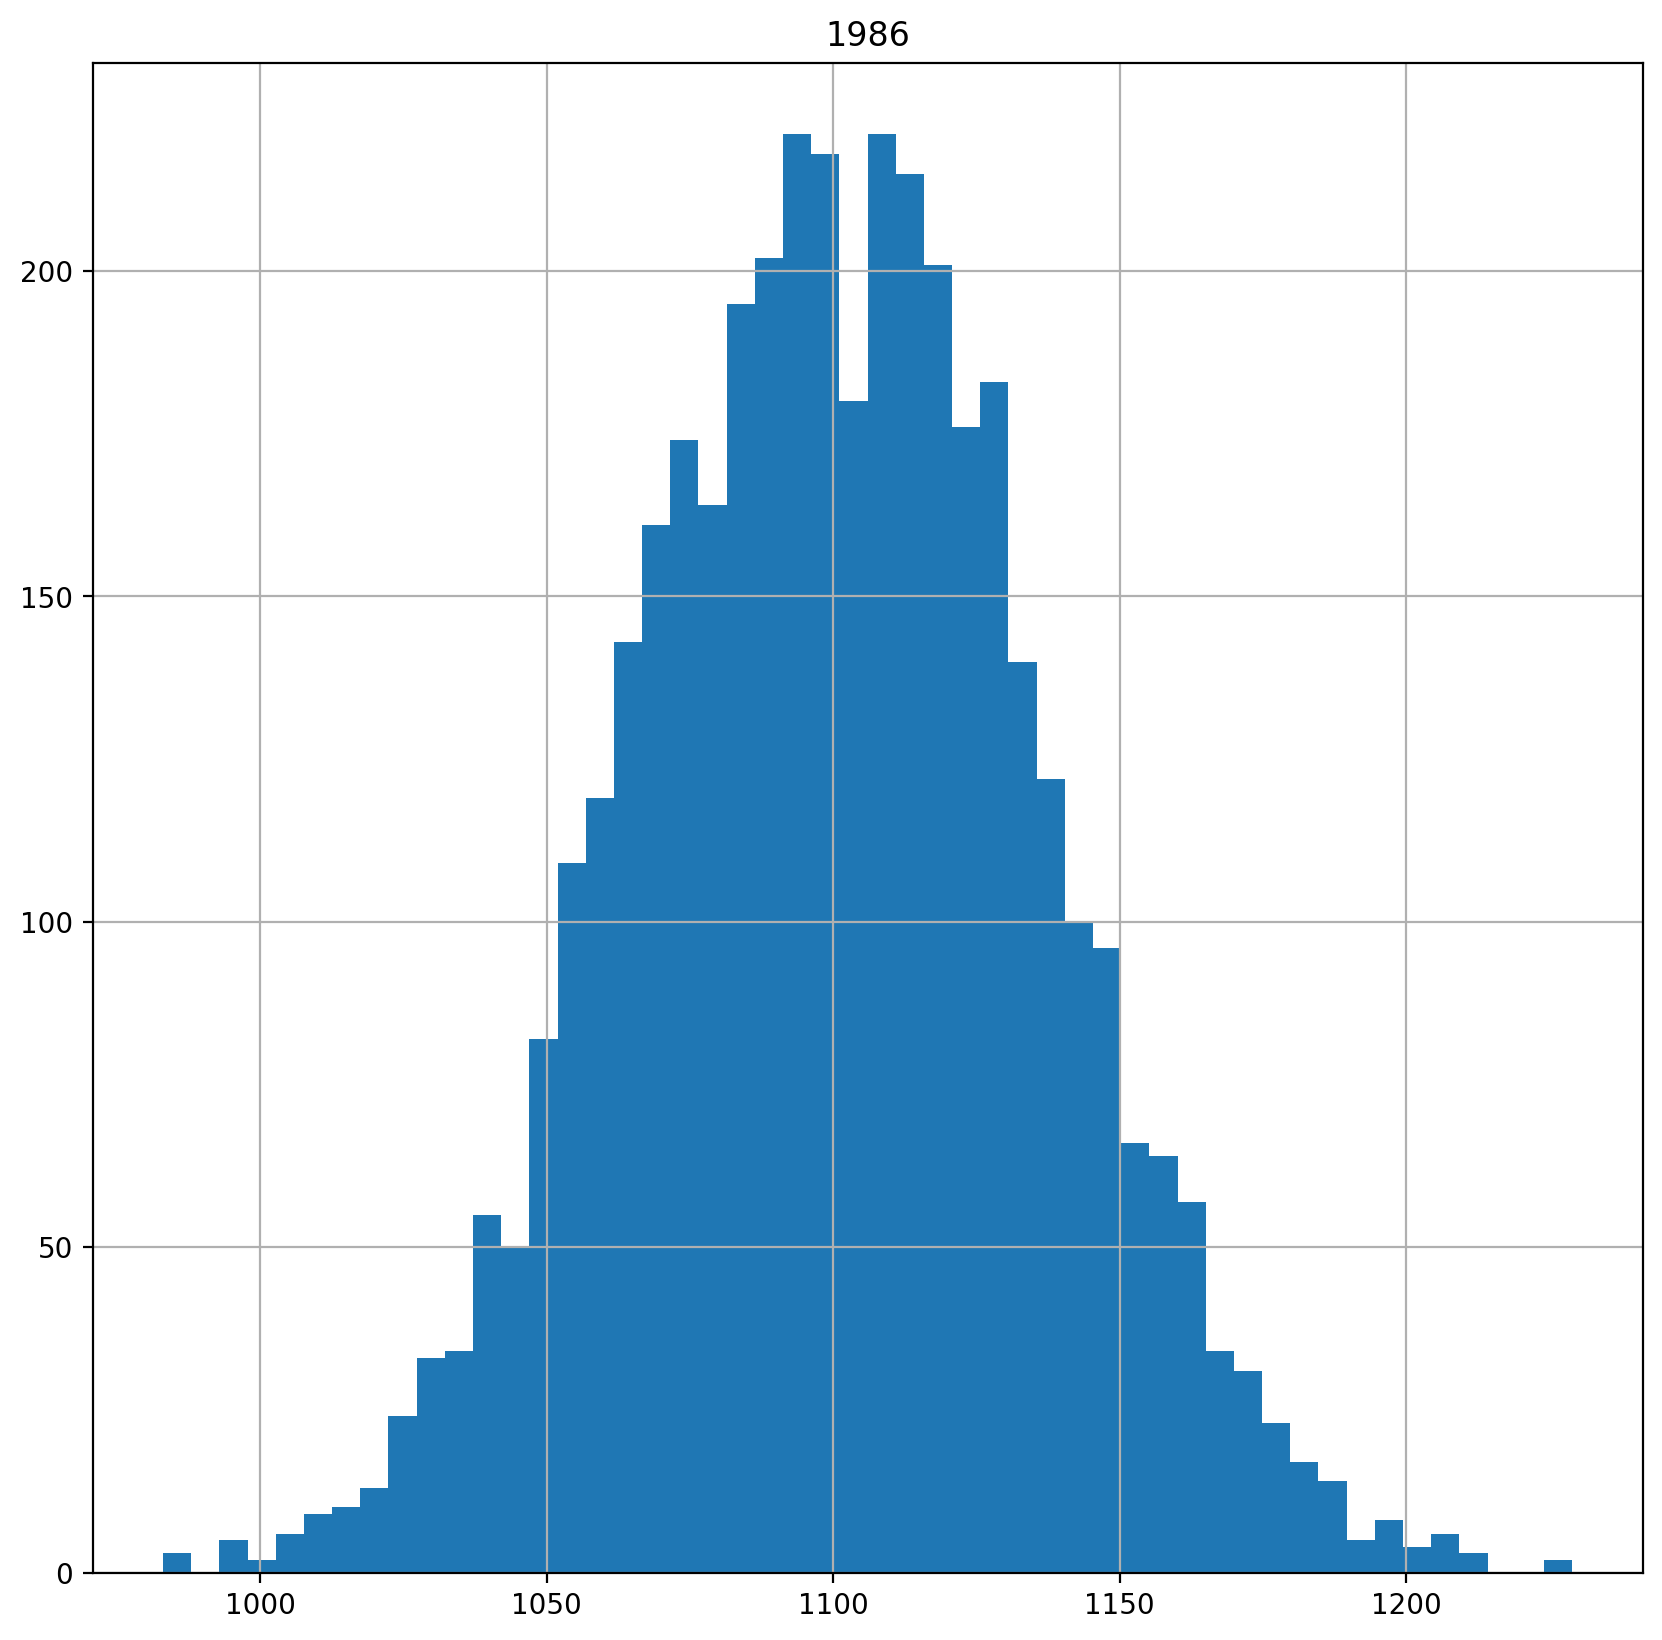

In [146]:
plt.figure(figsize = [10, 10])
plt.title('1986')
plt.hist(params1986, bins = 50)
plt.grid()
plt.show()